# Сборный проект № 2

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

Шаг 1. Откройте файл с данными и изучите общую информацию

In [261]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sb
import scipy.stats as stats
import plotly.express as px

In [208]:
# загружаем данные о событиях из CSV-файла в переменную 
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

In [209]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Шаг 2. Подготовьте данные
Замените названия столбцов на удобные для вас;
Проверьте пропуски и типы данных. Откорректируйте, если нужно;
Добавьте столбец даты и времени, а также отдельный столбец дат;

In [211]:
# заменим наименования столбцов
df.rename(columns = {'EventName':'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'group'}, inplace = True )

In [212]:
# проверим наличие пропущенных значений
df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

In [213]:
# проверим наличие явных дубликатов
print('Количество дубликатов в таблице:', df.duplicated().sum())

Количество дубликатов в таблице: 413


In [214]:
# посчитаем долю дубликатов в процентах
display(round(df.duplicated().sum()*100/len(df),2))

0.17

In [215]:
# удаляем дубликаты
df=df.drop_duplicates().reset_index(drop=True)

In [216]:
# приведем значения столбца event_timestamp к типу даты
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [217]:
# добавим отдельный столбец дат
df['date'] = df['event_timestamp'].dt.strftime('%Y-%m-%d')
#dt.round('1D')

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   group            243713 non-null  int64         
 4   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


In [219]:
df.head()

,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [220]:
# посмотрим уникальные названия событий
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Неявные дубликаты в датафрейме отсутствуют.

In [221]:
# проверим наличие пользователей, которые вошли в более, чем одну группу исследования
df.groupby('user_id').agg({'group': 'nunique'}).query('group > 1').count()


group    0
dtype: int64

In [222]:
# посмотрим, за какой период предоставлены данные
print('Данные о событиях за период с ',df['event_timestamp'].min(), ' по ', df['event_timestamp'].max())

Данные о событиях за период с  2019-07-25 04:43:36  по  2019-08-07 21:15:17


В ходе предобработки данных изменила наименования столбцов. Проведена проверка на наличие пропущенных значений: пропусков в датафрейме нет. Были выявлены и удалены 413 явных дубликатов. Изменила тип данных в столбце event_timestamp и добавила новый столбец, содержащий только дату события. Проверила пересечение групп: пользователей, вошедших в более чем одну группу, не обнаружено.
Итак, данные о событиях за период с 25.07.2019 по 07.08.2019 готовы к анализу.


Шаг 3. Изучите и проверьте данные
Сколько всего событий в логе?
Сколько всего пользователей в логе?
Сколько в среднем событий приходится на пользователя?
Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
Много ли событий и пользователей вы потеряли, отбросив старые данные?
Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [223]:
print('Общее количество событий в логе:', len(df))

Общее количество событий в логе: 243713


In [224]:
print('Количество уникальных пользователей в логе:', df['user_id'].nunique())

Количество уникальных пользователей в логе: 7551


In [225]:
print('В среднем на одного пользователя приходится', round(len(df)/df['user_id'].nunique(),0), 'событий')

В среднем на одного пользователя приходится 32.0 событий


Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [226]:
# сгруппируем данные по группам и датам совершения событий 
df_pivot = pd.pivot_table(df, index='date', columns='group', values='event_name', aggfunc='count').sort_values(by='date', ascending=True)
df_pivot.head()


group,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71


<Figure size 3000x500 with 0 Axes>

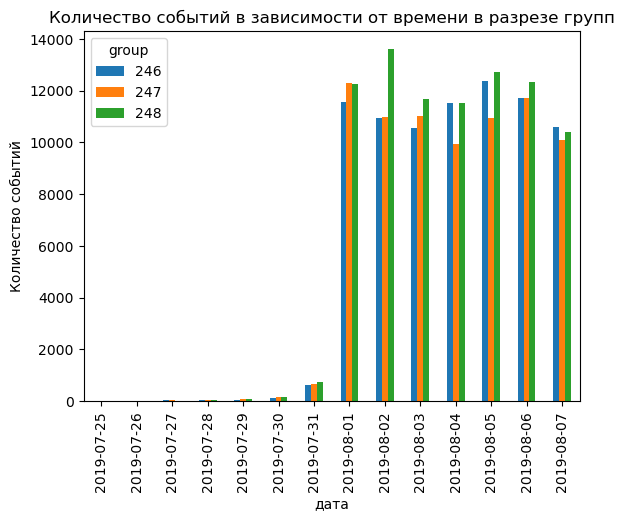

In [227]:
# построим столбчатую диаграмму
plt.figure(figsize=(30, 5))
df_pivot.plot.bar()
plt.locator_params (axis='x', nbins= 30)

plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.ylabel('Количество событий')
plt.xlabel('дата')
plt.show()

На диаграмме видно, что количество событий по 31.07.2019 очень мало. Это означает, что мы располагаем полными данными о событиях за период с 01.08.2019 по 07.08.2019.


Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

In [228]:
df_old = df[df['date'] <'2019-08-01']
df_old.head()

,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [229]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2826 entries, 0 to 2825
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_name       2826 non-null   object        
 1   user_id          2826 non-null   int64         
 2   event_timestamp  2826 non-null   datetime64[ns]
 3   group            2826 non-null   int64         
 4   date             2826 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 132.5+ KB


In [230]:
# объявим переменную, содержащую список пользователей в "старых" данных и выведем их количество
old_users = df_old['user_id'].unique()
print('количество уникальных пользователей в "старых" данных:', len(old_users))

количество уникальных пользователей в "старых" данных: 1451


In [231]:
# отбросим "старые" данные
df_new = df.query('user_id not in @old_users').reset_index()

Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [232]:
print('количество событий, потерянных в результате отброса старых данных:',len(df) - len(df_new))

количество событий, потерянных в результате отброса старых данных: 60057


Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [233]:
df_group = df_new.groupby('group')['user_id'].nunique().reset_index()
df_group

,group,user_id
0,246,2030
1,247,2036
2,248,2034


In [234]:
# относительное различие количества пользователей между группами 246 и 248
print('относительное различие количества пользователей между группами 246 и 248:',round((1-df_group.loc[0,'user_id']/df_group.loc[2,'user_id'])*100,2),'%')

относительное различие количества пользователей между группами 246 и 248: 0.2 %


In [235]:
# относительное различие количества пользователей между группами 247 и 248
print('относительное различие количества пользователей между группами 247 и 248:',round((1-df_group.loc[1,'user_id']/df_group.loc[2,'user_id'])*100,2),'%')

относительное различие количества пользователей между группами 247 и 248: -0.1 %


Вывод: В логе всего 243713 событий и 7551 уникальных пользователей. В среднем на пользователя приходится 32 события.
Мы располагаем данными о событиях за период с 25.07.2019 по 07.08.2019. Однако, изучив столбчатую диаграмму "Количество событий в зависимости от времени в разрезе групп", можно сказать, что мы располагаем полными данными о событиях за период с 01.08.2019 по 07.08.2019.
Так как технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого, это может «перекашивать данные». Отбросили "старые" данные по 1451 уникальному пользователю. При этом мы теряем 60057 событий. 
Но при этом группы теста распределились равномерно, относительное различие количества пользователей между группами 246 и 248 и между группами 247 и 248 незначительно: 0,2% и -0,1% соответственно.

Шаг 4. Изучите воронку событий
Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

In [236]:
# Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Просмотр главной страницы - самое частовстречающееся событие, самое непопулярное - просмотр обучающего материала

In [237]:
# Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей.
df_funnel = df.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)
df_funnel

,event_name,user_id
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
0,CartScreenAppear,3749
3,PaymentScreenSuccessful,3547
4,Tutorial,847


In [254]:
# построим воронку событий
fig = px.funnel(df_funnel, x=list(df_funnel['user_id']), y=list(df_funnel['event_name']))
fig.show()

Посчитайте долю пользователей, которые хоть раз совершали событие.

In [239]:
# добавим столбец с общим количеством пользователей
df_funnel['total'] = df['user_id'].nunique()

In [240]:
# добавим столбец с долей пользователей, которые хоть раз совершали событие
df_funnel['part'] = round(df_funnel['user_id']/df_funnel['total'],3)
df_funnel

,event_name,user_id,total,part
1,MainScreenAppear,7439,7551,0.985
2,OffersScreenAppear,4613,7551,0.611
0,CartScreenAppear,3749,7551,0.496
3,PaymentScreenSuccessful,3547,7551,0.470
4,Tutorial,847,7551,0.112


Можно предположить, что события выстраиваются в следующую цепочку событий: просмотр главной страницы, просмотр предложений, вход в корзину и оплата заказа. Событие Tutorial (просмотр инструкций) пользователь может совершить на любом шаге. И количество пользователей, совершивших данное действие, очень мало, всего 11% пользователей совершали данное событие.
С другой стороны, можно предположить, что событие OffersScreenAppear также может быть пропущено пользователем. Например, товар был добавлен в корзину пользователем ранее, а в данный период он решил совершить покупку.
В реальности следовало бы уточнить у заказчика логическую цепочку событий.
Также следует отметить, что в нашем логе около 1,5% уникальных пользователей не заходили на главную страницу. Скорее всего, данное событие просто произошло ранее начала периода, за который у  нас имеются данные.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [241]:
print('доля пользователей, перешедших от просмотра главного экрана к экрану с предложениями:',\
      round(df_funnel.loc[2,'part']/df_funnel.loc[1,'part'],2))


доля пользователей, перешедших от просмотра главного экрана к экрану с предложениями: 0.62


In [242]:
print('доля пользователей, перешедших от просмотра предложений к просмотру корзины:',\
      round(df_funnel.loc[0,'part']/df_funnel.loc[2,'part'],2))

доля пользователей, перешедших от просмотра предложений к просмотру корзины: 0.81


In [243]:
print('доля пользователей, перешедших от просмотра корзины к совершению покупки:',\
      round(df_funnel.loc[3,'part']/df_funnel.loc[0,'part'],2))

доля пользователей, перешедших от просмотра корзины к совершению покупки: 0.95


Больше всего пользователей теряется на первом шаге. 62% пользователей переходят с главной страницы на страницу с предложениями.
Какая доля пользователей доходит от первого события до оплаты?

In [244]:
print('доля пользователей, которые доходят от просмотра главной страницы к совершению покупки:',\
      round(df_funnel.loc[3,'part']/df_funnel.loc[1,'part'],2))

доля пользователей, которые доходят от просмотра главной страницы к совершению покупки: 0.48


Вывод: Исходя из имеющихся данных, чаще всего пользователи совершают событие "MainScreenAppear" - 119101 случаев. Событие Tutorial случается редко, всего 1018 случаев. Предположим, что события выстраиваются в следующую цепочку событий: просмотр главной страницы, просмотр предложений, вход в корзину и оплата заказа. Событие Tutorial (просмотр инструкций) пользователь может совершить на любом шаге. И количество пользователей, совершивших данное действие, очень мало, всего 11% пользователей совершали данное событие.
С другой стороны, можно предположить, что событие OffersScreenAppear также может быть пропущено пользователем. Например, товар был добавлен в корзину пользователем ранее, а в данный период он решил совершить покупку.
В реальности следовало бы уточнить у заказчика логическую цепочку событий.
Также следует отметить, что в нашем логе около 1,5% уникальных пользователей не заходили на главную страницу. Скорее всего, данное событие просто произошло ранее начала периода, за который у  нас имеются данные.
Доля пользователей, прошедших цепочку событий от главного экрана до покупки составила 48%.

Шаг 5. Изучите результаты эксперимента
Сколько пользователей в каждой экспериментальной группе?
Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [245]:
df_group

,group,user_id
0,246,2030
1,247,2036
2,248,2034


Итак, мы имеем 3 группы теста. Количество пользователей в группах приблизительно одинаково, относительное различие количества пользователей между группами 246 и 248 и между группами 247 и 248 незначительно: 0,2% и -0,1% соответственно.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [246]:
df_new

,index,event_name,user_id,event_timestamp,group,date
0,2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...,...
183651,243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
183652,243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
183653,243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
183654,243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [257]:
# отфильтруем данные по группам
df_246 = df_new.query('group == 246')


,index,event_name,user_id,event_timestamp,group,date
0,2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
6,2832,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01
...,...,...,...,...,...,...
183650,243707,MainScreenAppear,5746969938801999050,2019-08-07 21:12:11,246,2019-08-07
183652,243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
183653,243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
183654,243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [258]:
df_247 = df_new.query('group == 247')


In [259]:
# сгруппируем данные по событиям
df_A246 = df_246.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)
df_A246

,event_name,user_id
1,MainScreenAppear,2003
2,OffersScreenAppear,1272
0,CartScreenAppear,1030
3,PaymentScreenSuccessful,977
4,Tutorial,274


In [260]:
df_A247 = df_247.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)
df_A247

,event_name,user_id
1,MainScreenAppear,2009
2,OffersScreenAppear,1236
0,CartScreenAppear,1001
3,PaymentScreenSuccessful,933
4,Tutorial,281


Сравним доли клиентов, сделавших заказ. Проверим гипотезу о равенстве пропорций заказов в двух группах 246 и 247.
Нулевая гипотеза: доли клиентов, сделавших заказ в группе 246 и в группе 247 равны
Альтернативная гипотеза: доли клиентов, сделавших заказ в группе 246 и в группе 247 не равны

In [263]:

alpha = .05 # критический уровень статистической значимости

successes = np.array([274, 281])
trials = np.array([2003, 2009])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7778338881984832
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
